# *Linear Regression (Baseline Model)*

In [2]:
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, f_regression


## *Feature Engineering*

The baseline model will be a linear regression model that considers a selection of engineered features. These will consist of the rolling variance and mean, and lag taken at various time intervals. This model will predict the next interval along for each of the hourly, daily, and weekly granularities.

<center>

|Granularity|Window Sizes|
|-----------|------------|
|Hourly     |6h, 12h, 24h|
|Daily      |7d, 14d, 30d|
|Weekly     |2w, 4w, 8w  |


<center>


In [3]:
# Load DataFrames
LCL_hrs = pd.read_pickle('data/LCL_unstack_hrs.pkl')
LCL_day = pd.read_pickle('data/LCL_unstack_day.pkl')
LCL_wks = pd.read_pickle('data/LCL_unstack_wks.pkl')

In [4]:
# Find rolling variances and means, and lags for each tariff

DF_names = []
DF_list = []

# Define windows for each DataFrame
DF_dict = {
   'DF':[LCL_hrs, LCL_day, LCL_wks],                    # List the DataFrames
   'period':['_hrs','_day','_wks'],                     # Periods used to name output DataFrames
   'letter':['h_', 'd_', 'w_'],                         # Suffixes used to name columns in output DataFrames
   'n_ints':[[6, 12, 24], [7, 14, 30], [2, 4, 8]],      # Specify number of points to include in window/points to lag
}

for i in range(len(DF_dict['DF'])):        # Loop through index
    DF = DF_dict['DF'][i]                  # Select DataFrame
    p_suf = DF_dict['period'][i]           # Select suffixes for naming
    l_suf = DF_dict['letter'][i]
    n_ints = DF_dict['n_ints'][i]          # Select list of windows

    for col in DF.columns:                                              # Loop through Std and Tou columns
        df = (pd.DataFrame(DF[col])).rename(columns = {col:'KW'})       # New DataFrame for each column

        for j in n_ints:                                                # Loop through windows
            df[str(j)+l_suf+'var'] = df['KW'].rolling(j).var().shift()  # Calculate rolling variance
            df[str(j)+l_suf+'avg'] = df['KW'].rolling(j).mean().shift() # Calculate rolling mean
            df[str(j)+l_suf+'lag'] = df['KW'].shift(periods = j)        # Find lag

        df.dropna(inplace = True)                              # Drop nulls due to rolling window
        globals()[col + p_suf + '_df'] = df.copy()             # Name output DataFrame
        DF_list.append(globals()[col + p_suf + '_df'])         # Keep track of DataFrames for corellation plots
        DF_names.append(col + p_suf + '_df')                   # Keep track of DataFrame names for corellation plots

In [5]:
# Create checkpoint
# pd.to_pickle(DF_dict, 'data/DF_dict.pkl')

## *Checking for Correlation and Multi-Colinearity*

We can plot a correlation heatmap for all the engineered features to examine how much they correlate with the target variable `KW`, and therefore how predictive they might be. 

The correlation matrices also show the correlation between each of the engineered features. High correlation between features implies multi-colinearity, that is, one feature may be predictive of another. Significant correlation between features suggests that features could be dropped from the set of independent variables.

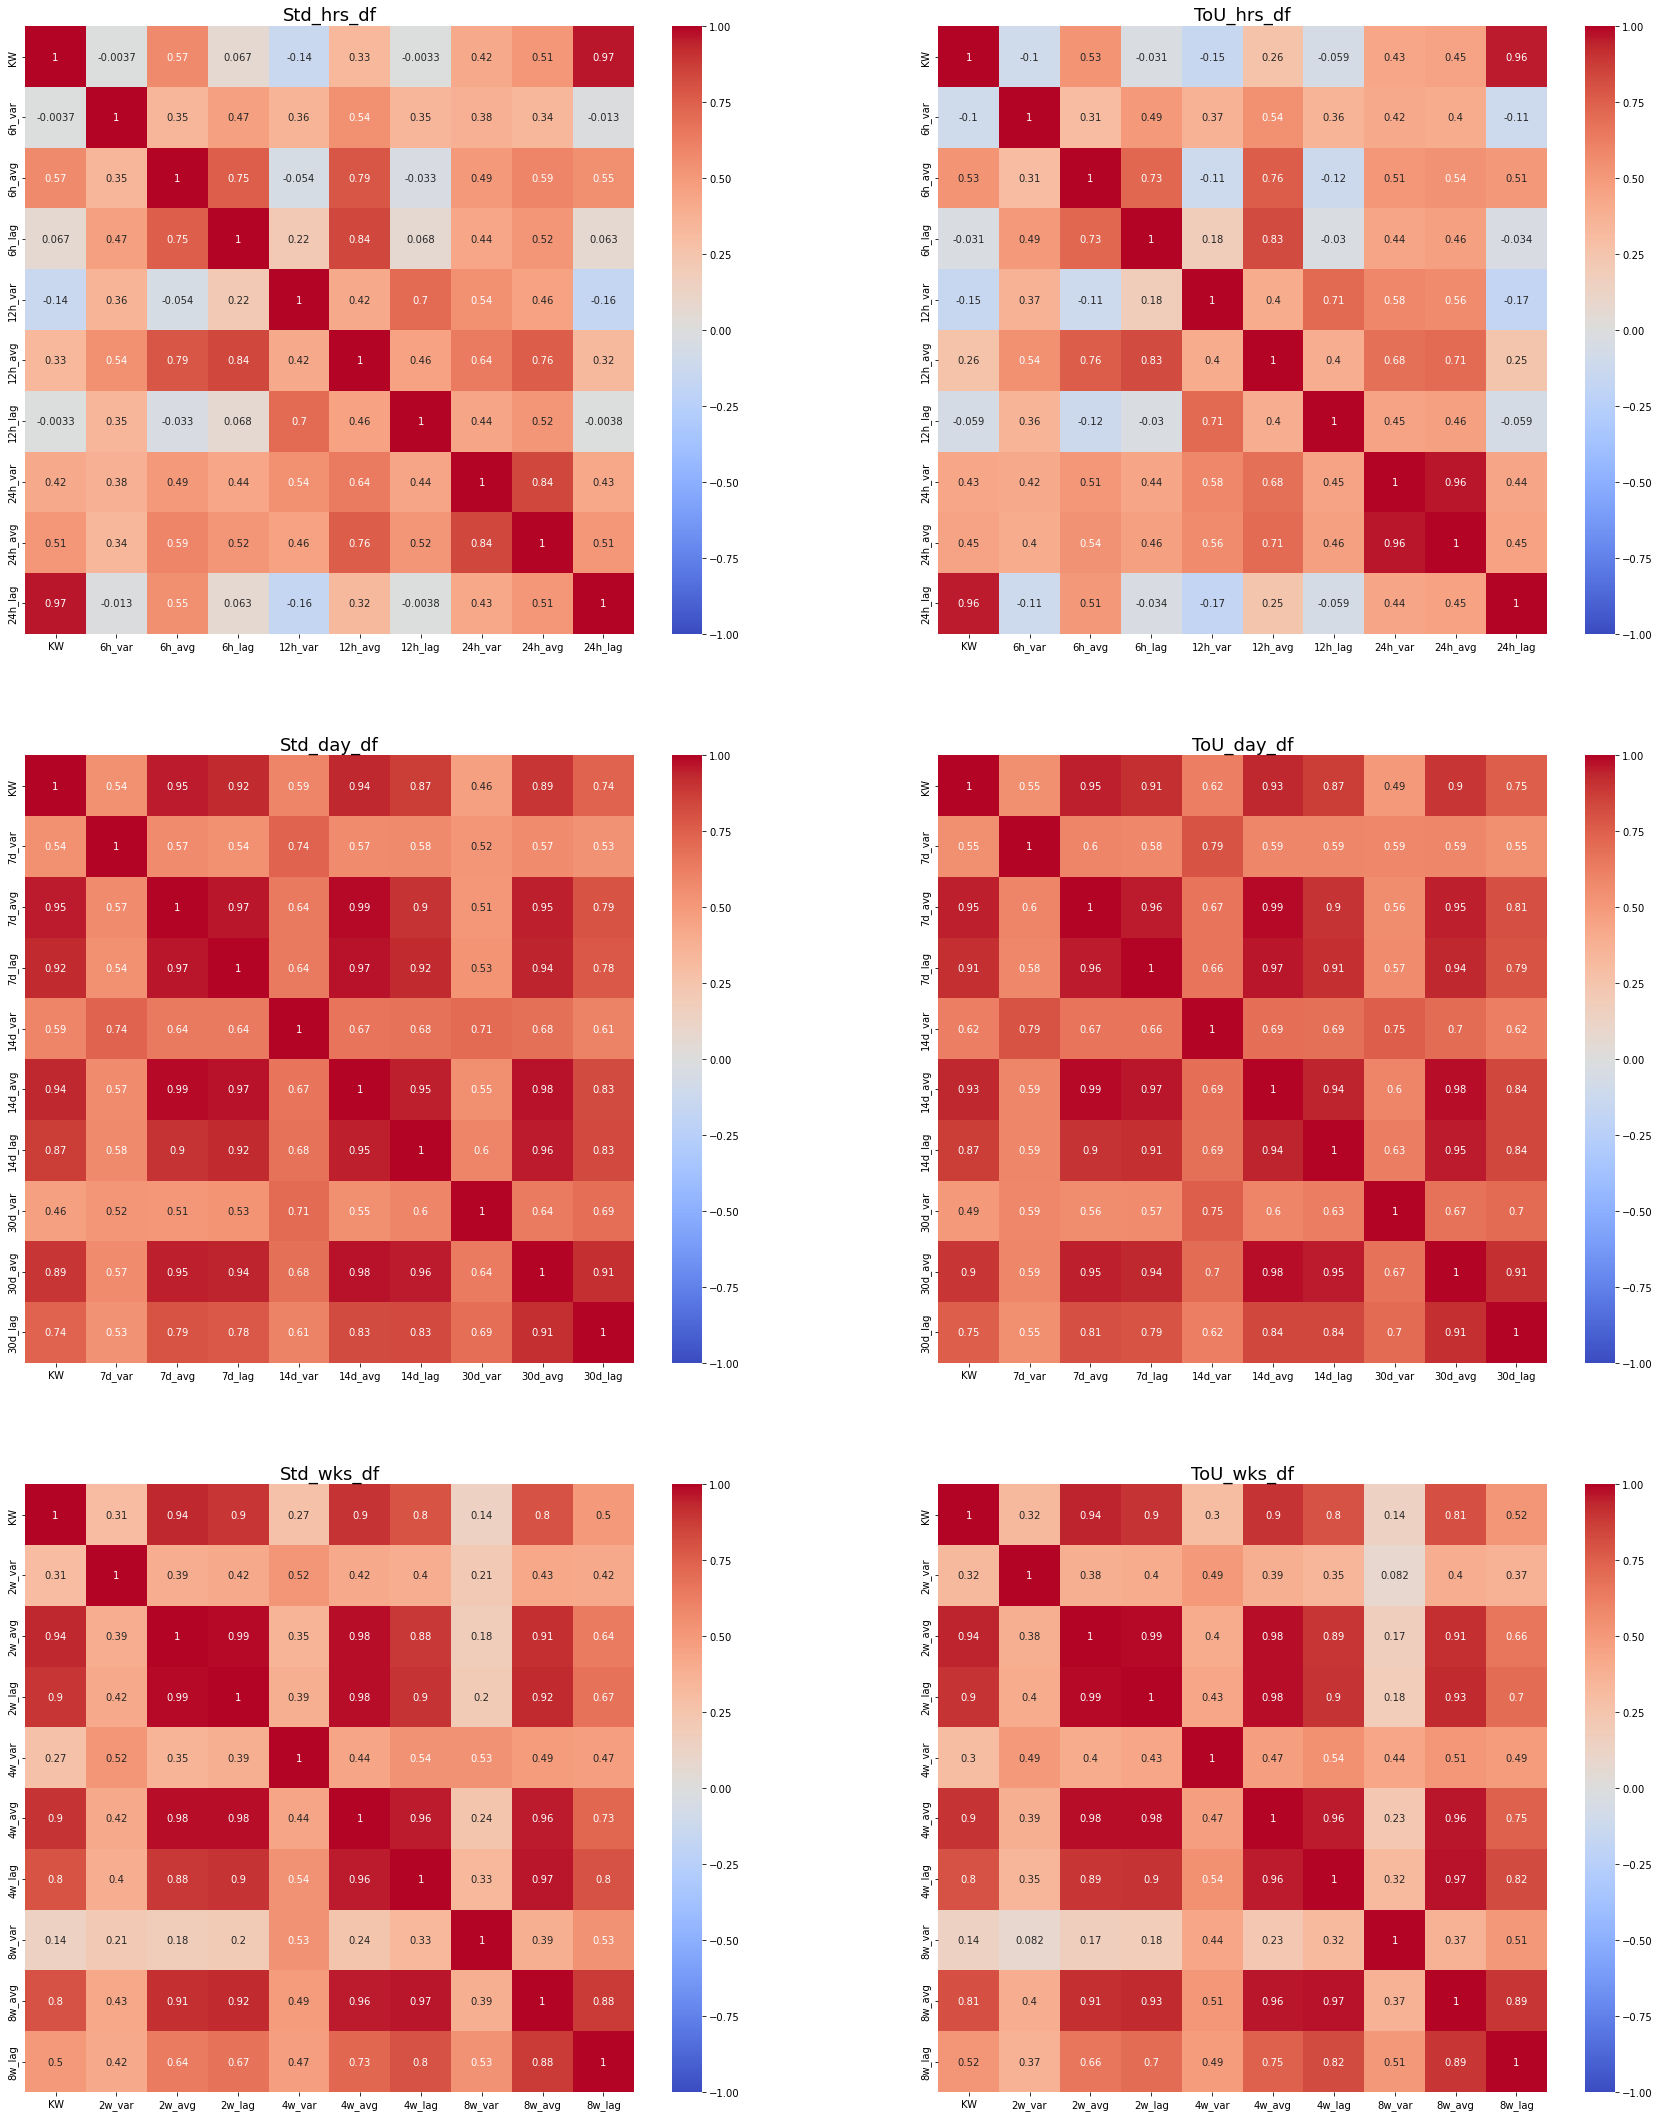

In [6]:
plt.subplots(3,2, figsize = (30,38))
count = 1

for i in range(len(DF_list)):
    df = DF_list[i]
    name = DF_names[i]
    plt.subplot(3,2,count)
    sns.heatmap(df.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm')
    plt.title(name, fontsize = 18)
    count +=1


plt.show()

## *Model Optimisation*
We will use try a range of linear regression models to find the optimal solution for each granularity and tariff type. This will be done using a 5 fold, cross validated grid search which will compare Linear Regression, Lasso Regression, and Ridge Regression models.

The grid search will also consider scaled and unscaled data, as well as dimensionality reduction using PCA, and using `SelectKBest` to find the single most correlated feature.

To score our models, we will use the mean absolute percentage error (MAPE). The magnitude of the dataset is small so naturally, metrics such as mean absolute error (MAE), mean squared error (MSE), and root mean squared error (RMSE), will also be small and thus difficult to interpret. The MAPE gives us the error as a percentage. The value will therefore scale with the magnitude of our data.

Especially at larger granularities, the point to point difference is small. This means that a model could forecast a point by simply using a 1 point lag as the prediction and still produce an accurate result. We will therefore also calculate the MAPE for the 1 point lag of the test set to serve as a comparison for the optimised linear models.

In [22]:
def do_linear (df):
    '''
    Helper function to find optimised model for each tariff and granularity.
    Runs a grid search on LinearRegression, Ridge, and Lasso models.
    Considers dimensionality reduction with PCA, and SelectKBest to extract most correlated feature.

    Prints best model, 1 point lag, and CV and test MAPE values.

    -------
    INPUT:
    -------
    df: DataFrame of dependent and independent variables.
    '''

    from sklearn.metrics import mean_absolute_percentage_error

    y = df['KW']
    X = df.drop(columns = 'KW')
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 8)

    X_test = X.tail(round(0.2*len(X)))
    X_train = X.loc[X.index < X_test.index[0]]

    y_test = y.tail(round(0.2*len(y)))
    y_train = y.loc[y.index < y_test.index[0]]

    estimators = [
        ('scale', StandardScaler()),
        ('reduce', PCA()),
        ('model', LinearRegression())
        ]

    pipe = Pipeline(estimators)

    params = [
        {'scale':[StandardScaler(), None],
        'reduce':[PCA()],
        'reduce__n_components':[3, 4, 5, 6, 7, 8],
        'model':[LinearRegression()]},

        {'scale':[StandardScaler(), None],
        'reduce':[PCA()],
        'reduce__n_components':[3, 4, 5, 6, 7, 8],
        'model':[Lasso(random_state=8), Ridge(random_state=8)],
        'model__alpha':[10**x for x in range(-2,3)]},

         {'scale':[StandardScaler(), None],
        'reduce':[SelectKBest(score_func=f_regression, k=1), None],
        'model':[LinearRegression()]},

         {'scale':[StandardScaler(),None],
        'reduce':[SelectKBest(score_func=f_regression, k=1), None],
        'model':[Lasso(random_state=8), Ridge(random_state=8)],
        'model__alpha':[10**x for x in range(-2,3)]}

    ]

    grid_cv = GridSearchCV(pipe, params, cv=5,scoring='neg_mean_absolute_percentage_error', verbose=1)
    grid_fit = grid_cv.fit(X_train, y_train)
    best_model = grid_fit.best_estimator_.fit(X_train, y_train)
    test_preds = best_model.predict(X_test)
    test_mape = round(mean_absolute_percentage_error(y_test, test_preds)*100, 2)
    CV_mape = -round(max(grid_fit.cv_results_['mean_test_score'])*100, 2)
    lag_mape = round(mean_absolute_percentage_error(y_test.tail(-1), y_test.shift().dropna())*100, 2)

    print(f"===========================================================================================================\
            \nBest model found with grid search:\
            \n{grid_fit.best_params_}\
            \n-----------------------------------------------------------------------------------------------------------\
            \n\n1 point lagged MAPE:\
            \n{lag_mape}%\
            \n\nCross validation MAPE:\
            \n{CV_mape}%\
            \n\nTest MAPE:\
            \n{test_mape}%\
            \n===========================================================================================================\n\n\n")
    
    

In [23]:
for i in range(len(DF_list)):
    df = DF_list[i]
    df_name = DF_names[i]
    print(f"===================================== OPTIMISING MODEL FOR {df_name} =====================================")
    do_linear(df)

===================================== OPTIMISING MODEL FOR Std_hrs_df =====================================
Fitting 5 folds for each of 176 candidates, totalling 880 fits
Best model found with grid search:            
{'model': LinearRegression(), 'reduce': PCA(n_components=5), 'reduce__n_components': 5, 'scale': None}            
-----------------------------------------------------------------------------------------------------------            

1 point lagged MAPE:            
10.42%            

Cross validation MAPE:            
5.45%            

Test MAPE:            
5.44%            



===================================== OPTIMISING MODEL FOR ToU_hrs_df =====================================
Fitting 5 folds for each of 176 candidates, totalling 880 fits
Best model found with grid search:            
{'model': LinearRegression(), 'reduce': PCA(n_components=6), 'reduce__n_components': 6, 'scale': StandardScaler()}            
--------------------------------------------------

The output from the grid search has produced some reasonably accurate models. The test MAPE scores range from 2.69% to 6.62%. The models predicting on a weekly granularity performed best, whilst those predicting on an hourly granularity performed worst. This is expected, as variance will increase at smaller granularities, meaning that there will be more of a challenge in predicting the next point. This point can also be seen by comparing the test MAPE with the 1 point lag MAPE. At an hourly granularity, the optimised models perform almost 2x better than the simple lag model, whilst at a weekly granularity, the MAPE scores converge due to the low variance between points.

Therefore, whilst least accurate, the hourly models could arguably be the most valuable as they exhibit the most significant relative improvement over the 1 point lag model.